# Nortek AD2CP Processing, Testing, and Data Exploration

jgradone@marine.rutgers.edu     01/11/2022    Initial
nbronikowski@mun.ca             18/10/2023    Modifications+New Example

**This Jupyter Notebook is intended to:**<br>
1) Read glider data frome ERDDAP OR a local file <br> 
2) Read in AD2CP data processed to NetCDFs using the Nortek MIDAS software as an xarray DataSet and combine all into one massive DataSet <br>
3) Pull out just one glider segment (based on a unique file name) and the corresponding dead-reckoned depth average current. Use the start and end times to subset the AD2CP data <br>
4) Correct for local speed of sound <br>
5) QAQC AD2CP data <br>
6) Correct beams to level true-depth <br>
7) Bin map AD2CP data <br>
8) AD2CP Coordinate transformation from beam to XYZ to ENU <br>
9) Least squares linear inversion on ADCP velocities referenced to true ocean velocity through a depth averaged urrent constraint <br>
10) Save output from each segment<br>


*Details/comments on what the functions are actually doing in the source code*

In [1]:
# Imports
import scipy.interpolate as interp
from scipy.sparse.linalg import lsqr, lsmr
from scipy.sparse.linalg import inv
from scipy import integrate
import scipy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import netCDF4 as nc
import math
import datetime
import xarray as xr
import matplotlib.dates as mdates
import dask.array as da
from erddapy import ERDDAP
from netCDF4 import Dataset
import gsw
#import cmocean.cm as cmo
import sys
from datetime import datetime
import time


## To import functions from Slocum-AD2CP GitHub repository, make this path the path to where the repo exists locally
sys.path.insert(0,'../src/analysis/')
sys.path.insert(0,'../src/data/')
from make_dataset import correct_sound_speed, beam_true_depth, cell_vert, binmap_adcp, beam2enu, inversion, qaqc_pre_coord_transform, qaqc_post_coord_transform
from analysis import get_erddap_dataset

## Set some plotting formats
plt.style.use('seaborn-poster')
myFmtshort = mdates.DateFormatter('%m/%d\n%H:%M')
myFmtlong = mdates.DateFormatter('%m/%d/%y \n%H:%M')
myFmt = mdates.DateFormatter('%m/%d/%y')

/var/folders/yg/ysrmd5rn6ws__r62wj_q7n400000gp/T/ipykernel_3416/4286720526.py:33: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-poster')


## Step 1: Load glider data

In [2]:
nc_path = '/Users/research/Documents/Glider_Projects/2023_SpringBloomMission/data_springbloom/GliderData/';
filename = sorted(glob.glob(nc_path + '*.nc'))[0] 

ds = xr.open_dataset(filename, engine='netcdf4', decode_times=False)
ds = ds.sortby('time').to_dataframe().reset_index()
selected_vars_ds = ds[['time', 'depth', 'lat_qc', 'lon_qc','temperature','pressure',
                       'conductivity','salinity','profile_time','profile_index','profile_direction']]
#print(ds['time'].size)

ds_raw = xr.open_dataset(filename, engine='netcdf4', group='glider_record', decode_times=False)
ds_raw = ds_raw.sortby('time').to_dataframe().reset_index()


# Select specific variables from the second dataset
selected_vars_ds_raw = ds_raw[['time', 'm_heading', 'm_water_vx', 'm_water_vy']]

# Merge the selected variables from both datasets
gdf = pd.merge(selected_vars_ds, selected_vars_ds_raw, on='time', how='outer')

gdf = gdf.rename(columns={
    'temperature': 'sci_water_temp',
    'conductivity': 'sci_water_cond',
    'lon_qc': 'longitude',
    'lat_qc': 'latitude'
})

gdf['m_water_vx'] = gdf['m_water_vx'].interpolate(method='linear')
gdf['m_water_vy'] = gdf['m_water_vy'].interpolate(method='linear')
gdf = gdf.drop_duplicates(subset='time', keep='first')

gdf['time'] = pd.to_datetime(gdf['time'], unit='s')
gdf['profile_time'] = pd.to_datetime(gdf['profile_time'], unit='s', errors='coerce')

In [3]:
uprofs = gdf[gdf['profile_index'] % 1 == 0]['profile_index'].unique()

# Initialize lists to store start and end times
start_times = []
end_times = []

# Loop through unique profile indices
for up in uprofs:
    # Get indices of rows where profile_index is up and profile_direction is 1,
    # and where profile_index is up+1 and profile_direction is -1
    idx = gdf[
        ((gdf['profile_index'] == up) & (gdf['profile_direction'] == 1)) |
        ((gdf['profile_index'] == up + 1) & (gdf['profile_direction'] == -1))
    ].index
    
    # Check if idx is not empty
    if not idx.empty:
        # Extract time values corresponding to idx
        timeVec = gdf.loc[idx, 'time']
        #print(timeVec)
        
        # Calculate deltaTime in minutes
        deltaTime = (np.nanmax(timeVec) - np.nanmin(timeVec)) / np.timedelta64(1, 'm')
        
        # Check if deltaTime is greater than 20 minutes
        if deltaTime > 20:
            start_times.append(np.nanmin(timeVec))
            end_times.append(np.nanmax(timeVec))

# Convert lists to datetime format if needed
start_times = pd.to_datetime(start_times).tz_localize(None)
end_times = pd.to_datetime(end_times).tz_localize(None)

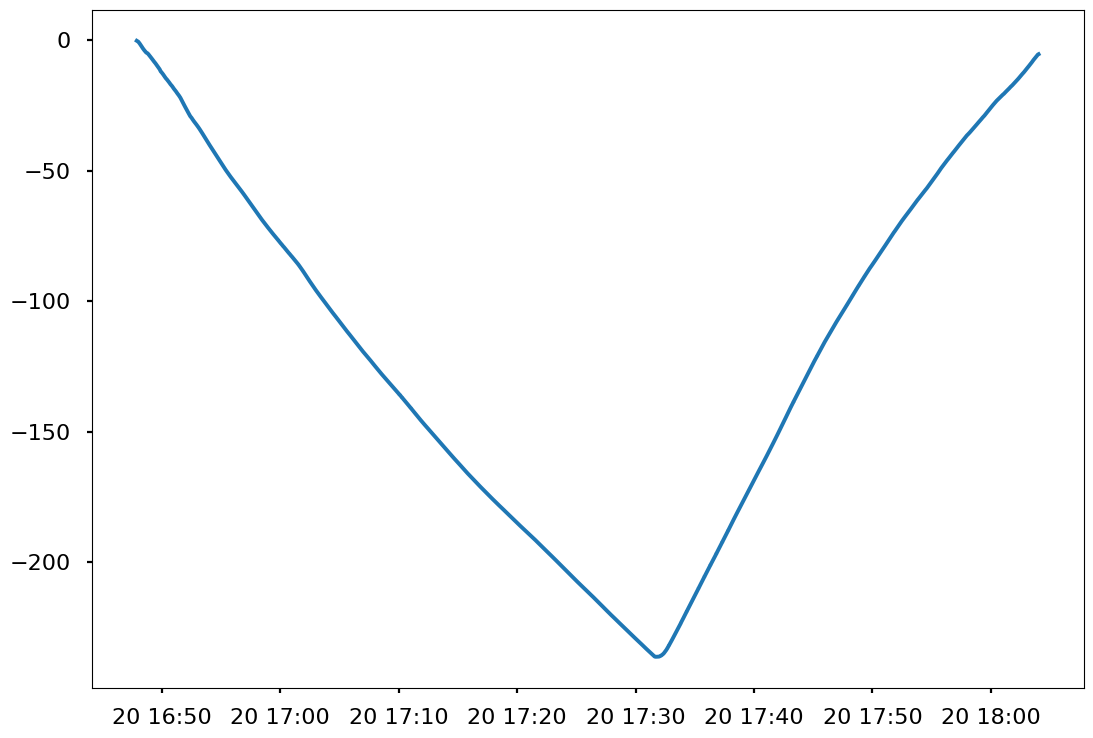

In [4]:
x=50
mask = (gdf.time >= start_times[x]) &  (gdf.time <= end_times[x])
plt.plot(gdf.time[mask],-gdf.depth[mask])

## Step 2: Load in AD2CP data frame

In [98]:
path = '/Users/research/Documents/Glider_Projects/2023_SpringBloomMission/data_springbloom/AD2CP_data/'
files = np.sort(glob.glob(path+'*000.nc'))
tot_ad2cp = xr.open_mfdataset(files,group='Data/Average/', concat_dim="time", combine="nested")
config = xr.open_dataset(files[0],group='Config')
tot_ad2cp = tot_ad2cp.assign_attrs(config.attrs)
tot_ad2cp = tot_ad2cp.rename({'Velocity Range':'VelocityRange',
                              'Correlation Range':'CorrelationRange',
                              'Amplitude Range':'AmplitudeRange'})
tot_ad2cp = tot_ad2cp.transpose()
tot_ad2cp.VelocityBeam1.shape

(30, 86838)

In [99]:
print(tot_ad2cp['VelocityRange'])

<xarray.DataArray 'VelocityRange' (VelocityRange: 30)>
array([ 1.2,  2.2,  3.2,  4.2,  5.2,  6.2,  7.2,  8.2,  9.2, 10.2, 11.2, 12.2,
       13.2, 14.2, 15.2, 16.2, 17.2, 18.2, 19.2, 20.2, 21.2, 22.2, 23.2, 24.2,
       25.2, 26.2, 27.2, 28.2, 29.2, 30.2], dtype=float32)
Coordinates:
  * VelocityRange  (VelocityRange) float32 1.2 2.2 3.2 4.2 ... 28.2 29.2 30.2
Attributes:
    units:        m
    description:  


## Correct Heading

In [100]:
import importlib
import NicolaiFunctions
importlib.reload(NicolaiFunctions)
from NicolaiFunctions import correct_ad2cp_heading

CorrectedHeading,Mag_xo,Mag_yo,Mag_x,Mag_y = correct_ad2cp_heading(tot_ad2cp['time'],tot_ad2cp['Heading'],tot_ad2cp['Pitch'],tot_ad2cp['Roll'], 
                                     tot_ad2cp['Pressure'],tot_ad2cp['MagnetometerX'],tot_ad2cp['MagnetometerY'],
                                     tot_ad2cp['MagnetometerZ'])

/Users/research/Documents/GitHub/Slocum-AD2CP/notebooks/NicolaiFunctions.py:49: RuntimeWarning: invalid value encountered in sqrt
  radii = np.sqrt(1. / evals)


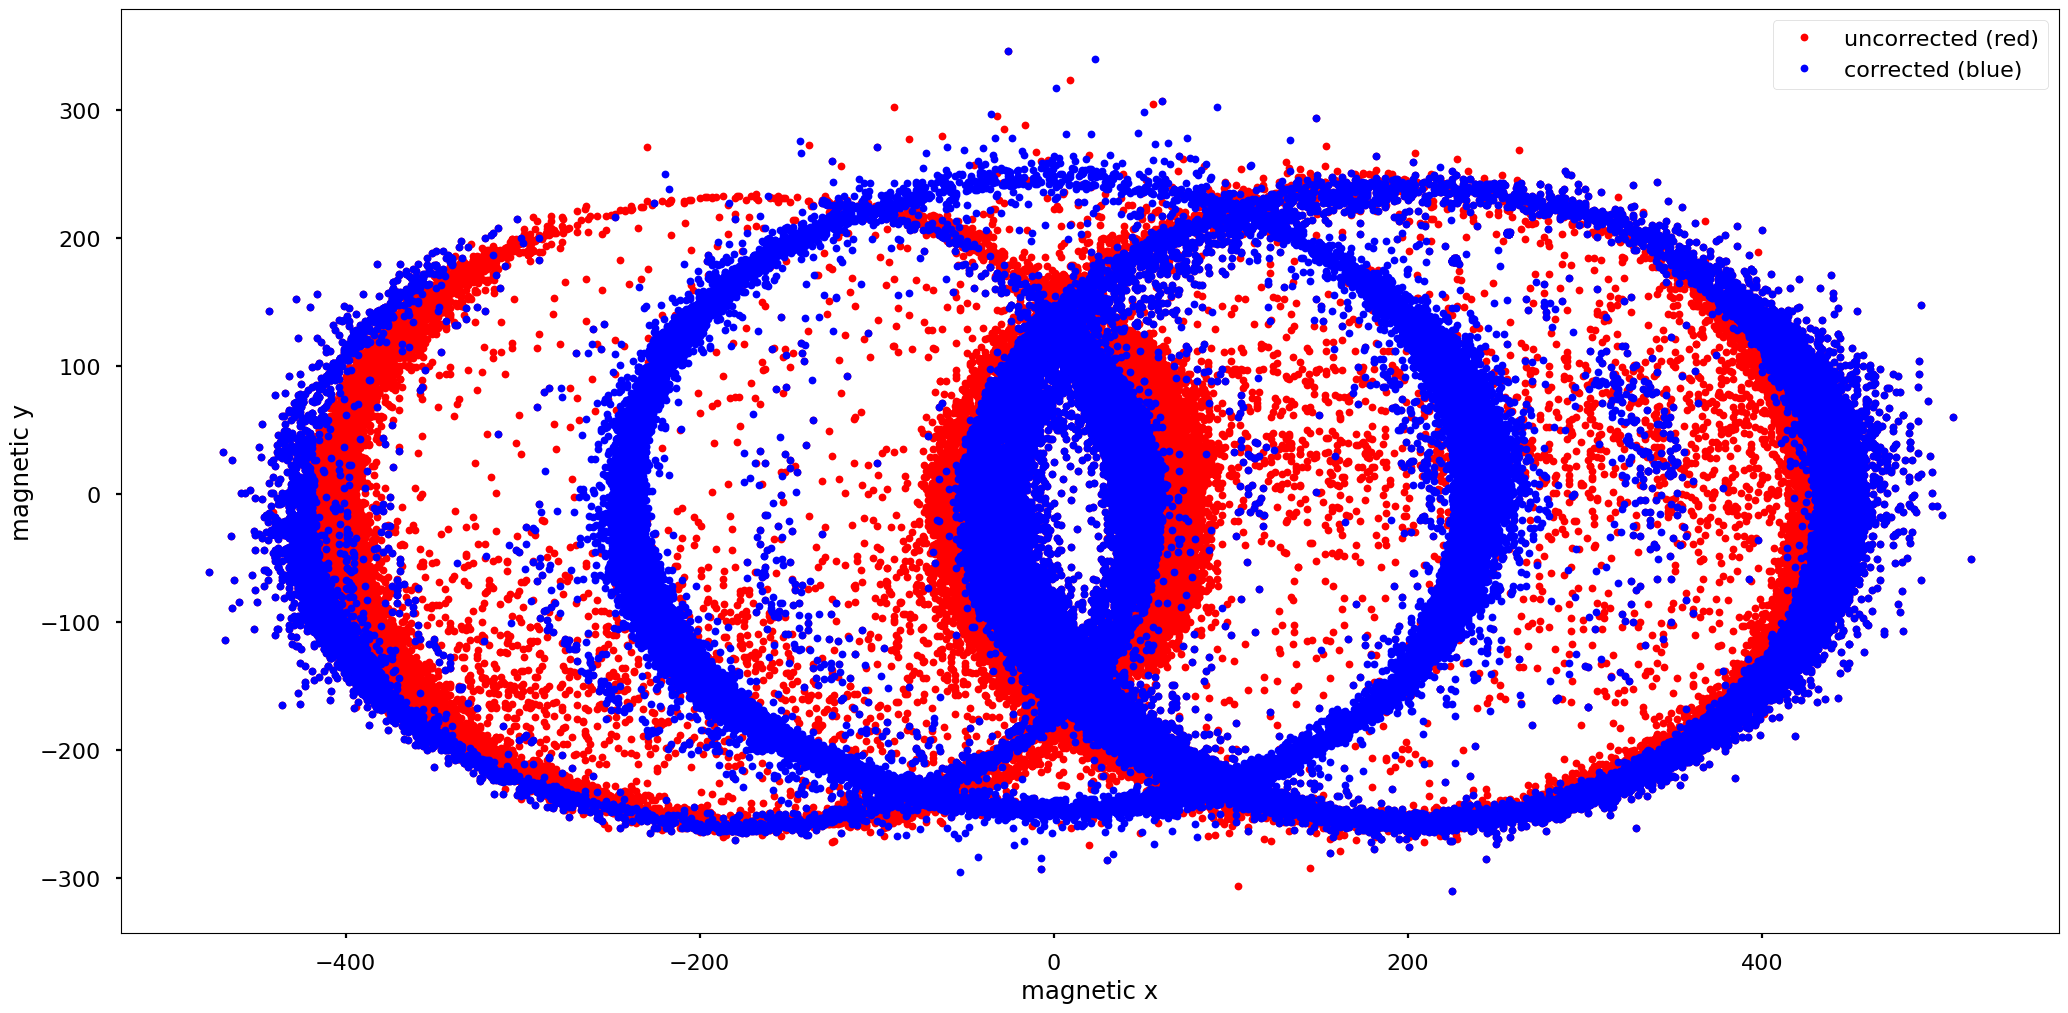

In [101]:
# heading correction
plt.figure(figsize=(25,12))
plt.plot(Mag_xo,Mag_yo, '.r', Mag_x, Mag_y, '.b')
plt.legend(['uncorrected (red)', 'corrected (blue)'])
plt.xlabel('magnetic x')
plt.ylabel('magnetic y')
plt.show()

In [102]:
# Now, add this DataArray to your dataset as a variable
tot_ad2cp['CorrectedHeading'] = xr.DataArray(CorrectedHeading, dims=['time'], coords={'time': tot_ad2cp.coords['time']})

## Step 3: Subset datasets
Pull out just one glider segment (based on a unique file name) and the corresponding dead-reckoned depth average current. Use the start and end times to subset the AD2CP data

In [104]:
## Just one file for testing
x = 1
subsetgdf = gdf[(gdf. time >= start_times[x]) & (gdf.time <= end_times[x])]
ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()
vx          = subsetgdf.m_water_vx.iloc[ind[-1]]
vy          = subsetgdf.m_water_vy.iloc[ind[-1]]
vx_lon      = np.nanmean(subsetgdf.longitude)
vx_lat      = np.nanmean(subsetgdf.latitude)
vx_start_tm = subsetgdf.time.iloc[0]
vx_end_tm   = subsetgdf.time.iloc[-1]

## Subset AD2CP dataframe based on segment start and end times
ad2cp_time_ind = np.where((tot_ad2cp.time >= start_times[x]) & (tot_ad2cp.time <= end_times[x]))[0]
subset_ad2cp = tot_ad2cp.sel(time=tot_ad2cp.time[ad2cp_time_ind])

In [105]:
subset_ad2cp

<xarray.Dataset>
Dimensions:                    (time: 172, VelocityRange: 30,
                                CorrelationRange: 30, AmplitudeRange: 30,
                                Physicalbeam_dim: 4)
Coordinates:
  * time                       (time) datetime64[ns] 2023-03-17T17:15:32.4385...
  * VelocityRange              (VelocityRange) float32 1.2 2.2 3.2 ... 29.2 30.2
  * CorrelationRange           (CorrelationRange) float32 1.2 2.2 ... 29.2 30.2
  * AmplitudeRange             (AmplitudeRange) float32 1.2 2.2 ... 29.2 30.2
Dimensions without coordinates: Physicalbeam_dim
Data variables: (12/44)
    VelocityBeam1              (VelocityRange, time) float32 dask.array<chunksize=(30, 172), meta=np.ndarray>
    VelocityBeam2              (VelocityRange, time) float32 dask.array<chunksize=(30, 172), meta=np.ndarray>
    VelocityBeam3              (VelocityRange, time) float32 dask.array<chunksize=(30, 172), meta=np.ndarray>
    VelocityBeam4              (VelocityRange, time) float32 dask.array<chunksize=(30, 172), meta=np.ndarray>
    CorrelationBeam1           (CorrelationRange, time) float32 dask.array<chunksize=(30, 172), meta=np.ndarray>
    CorrelationBeam2           (CorrelationRange, time) float32 dask.array<chunksize=(30, 172), meta=np.ndarray>
    ...                         ...
    WaterTemperature           (time) float32 dask.array<chunksize=(172,), meta=np.ndarray>
    Pressure                   (time) float64 dask.array<chunksize=(172,), meta=np.ndarray>
    Heading                    (time) float32 dask.array<chunksize=(172,), meta=np.ndarray>
    Pitch                      (time) float32 dask.array<chunksize=(172,), meta=np.ndarray>
    Roll                       (time) float32 dask.array<chunksize=(172,), meta=np.ndarray>
    CorrectedHeading           (time) float32 335.4 340.1 326.3 ... 207.6 206.3
Attributes: (12/386)
    instrumentOffsetTimeMatlab_description:       Offset from instrument time...
    File_ins_runTime:                             2333381000.0
    File_ins_runTime_description:                 Length of time data was col...
    File_ins_name:                                AD2CPRaw
    File_ins_name_description:                    Name of instrument
    File_ins_typeName:                            
    ...                                           ...
    instrumentOffsetTime:                         0.0
    instrumentOffsetTime_description:             Offset from instrument time...
    timeZoneOffset:                               -9000
    timeZoneOffset_description:                   Offset of platform local ti...
    instrumentOffsetTimeMatlab:                   0.0
    exportRevision:                               4489

## Take a quick peak at some data

/var/folders/yg/ysrmd5rn6ws__r62wj_q7n400000gp/T/ipykernel_3416/2703616999.py:8: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(x,-by,subset_ad2cp['AmplitudeBeam1'])


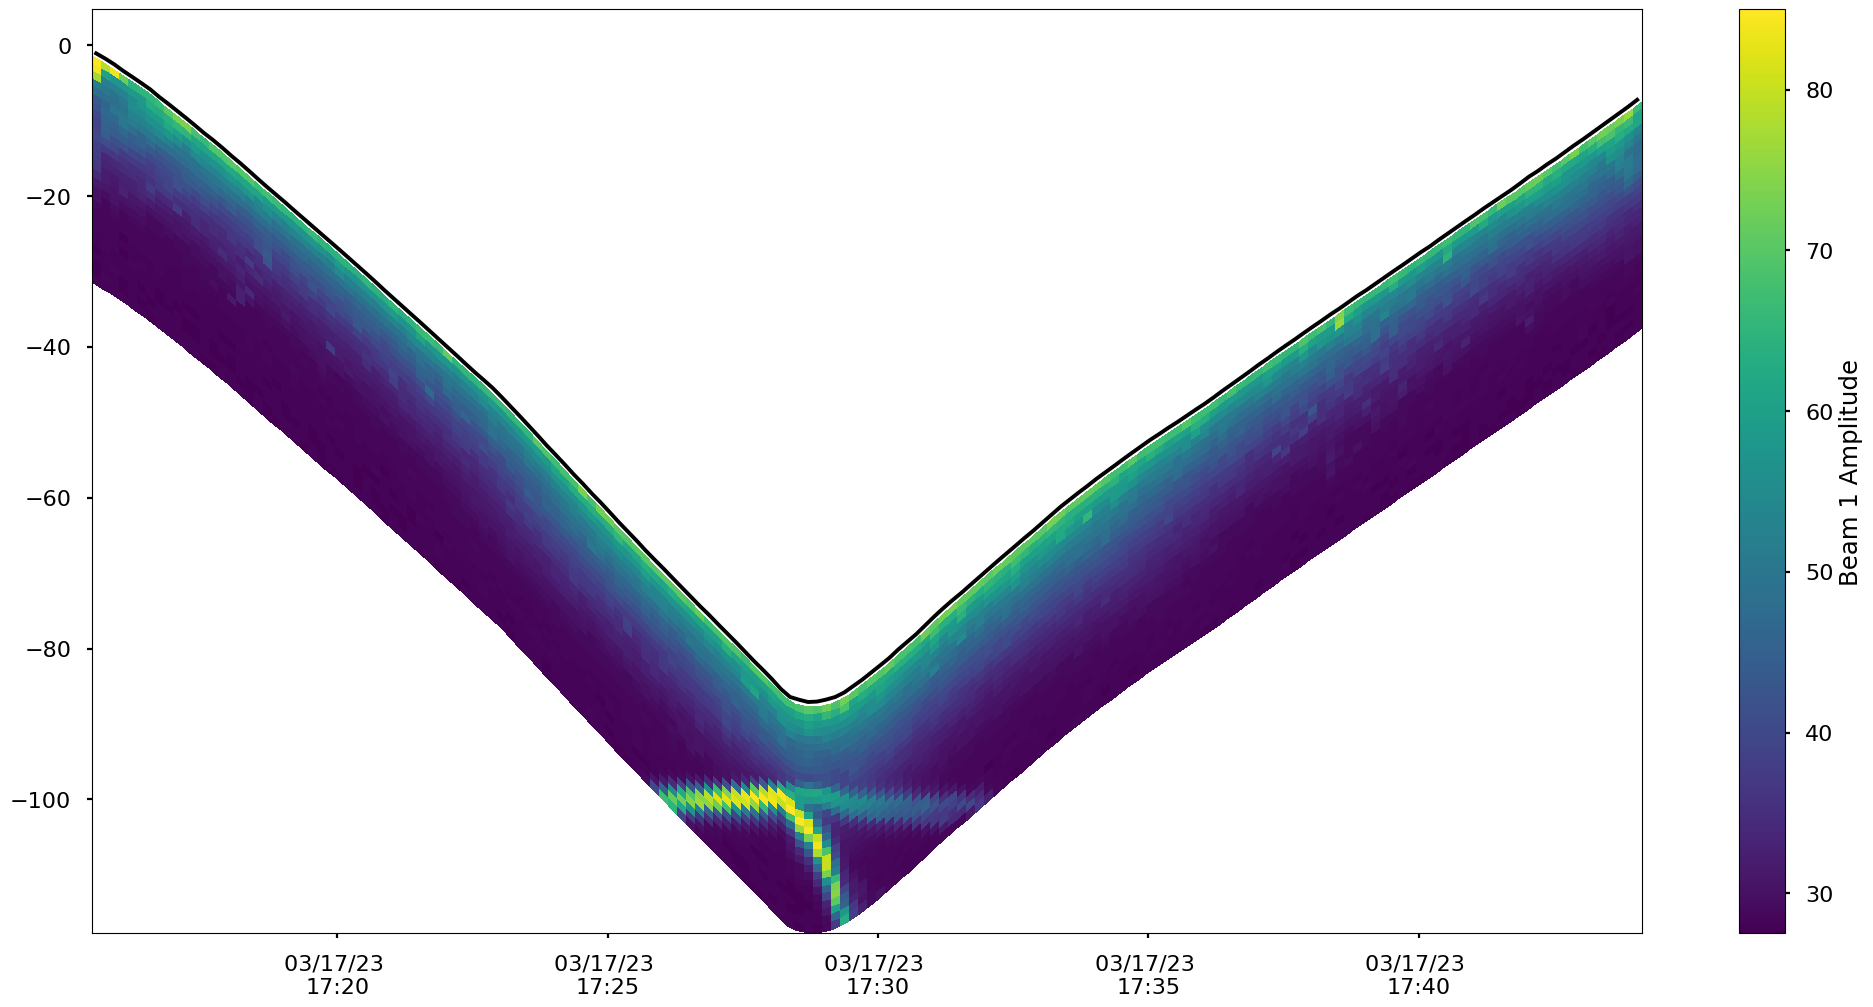

In [106]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Pressure'],subset_ad2cp['VelocityRange'])

by=bdepth+bbins

fig = plt.figure(figsize=(25,12))

plt.pcolormesh(x,-by,subset_ad2cp['AmplitudeBeam1'])
plt.plot(subset_ad2cp['time'],-subset_ad2cp['Pressure'],'k')
plt.colorbar(label='Beam 1 Amplitude')
plt.gca().xaxis.set_major_formatter(myFmtlong)

## Data Cleaning

In [107]:
# Remove some bad data
condition = (np.abs(subset_ad2cp.Roll.values) > 3) & (np.abs(subset_ad2cp.Pitch.values) < 10)
subset_ad2cp.VelocityBeam1[:,condition]=np.nan
subset_ad2cp.VelocityBeam2[:,condition]=np.nan
subset_ad2cp.VelocityBeam3[:,condition]=np.nan
subset_ad2cp.VelocityBeam4[:,condition]=np.nan

## Step 4: Correct for local speed of sound (Fischer and Visbeck, 1993)


In [108]:
## Correct for local speed of sound
subset_ad2cp = correct_sound_speed(subset_ad2cp)

## Step 5: Filter for Extreme Amplitude Returns and Below 0.5 Correlation (Todd et al. 2017)

In [109]:
## QAQC pre-coordinate transformation
subset_ad2cp = qaqc_pre_coord_transform(subset_ad2cp, corr_threshold = 50, max_amplitude = 75)

## Processing Step 6: Correct beams to level true-depth

In [110]:
## Correct beams to level true-depth
subset_ad2cp = beam_true_depth(subset_ad2cp) 

/var/folders/yg/ysrmd5rn6ws__r62wj_q7n400000gp/T/ipykernel_3416/2920521969.py:5: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(x,-by,subset_ad2cp['VelocityBeam1'])


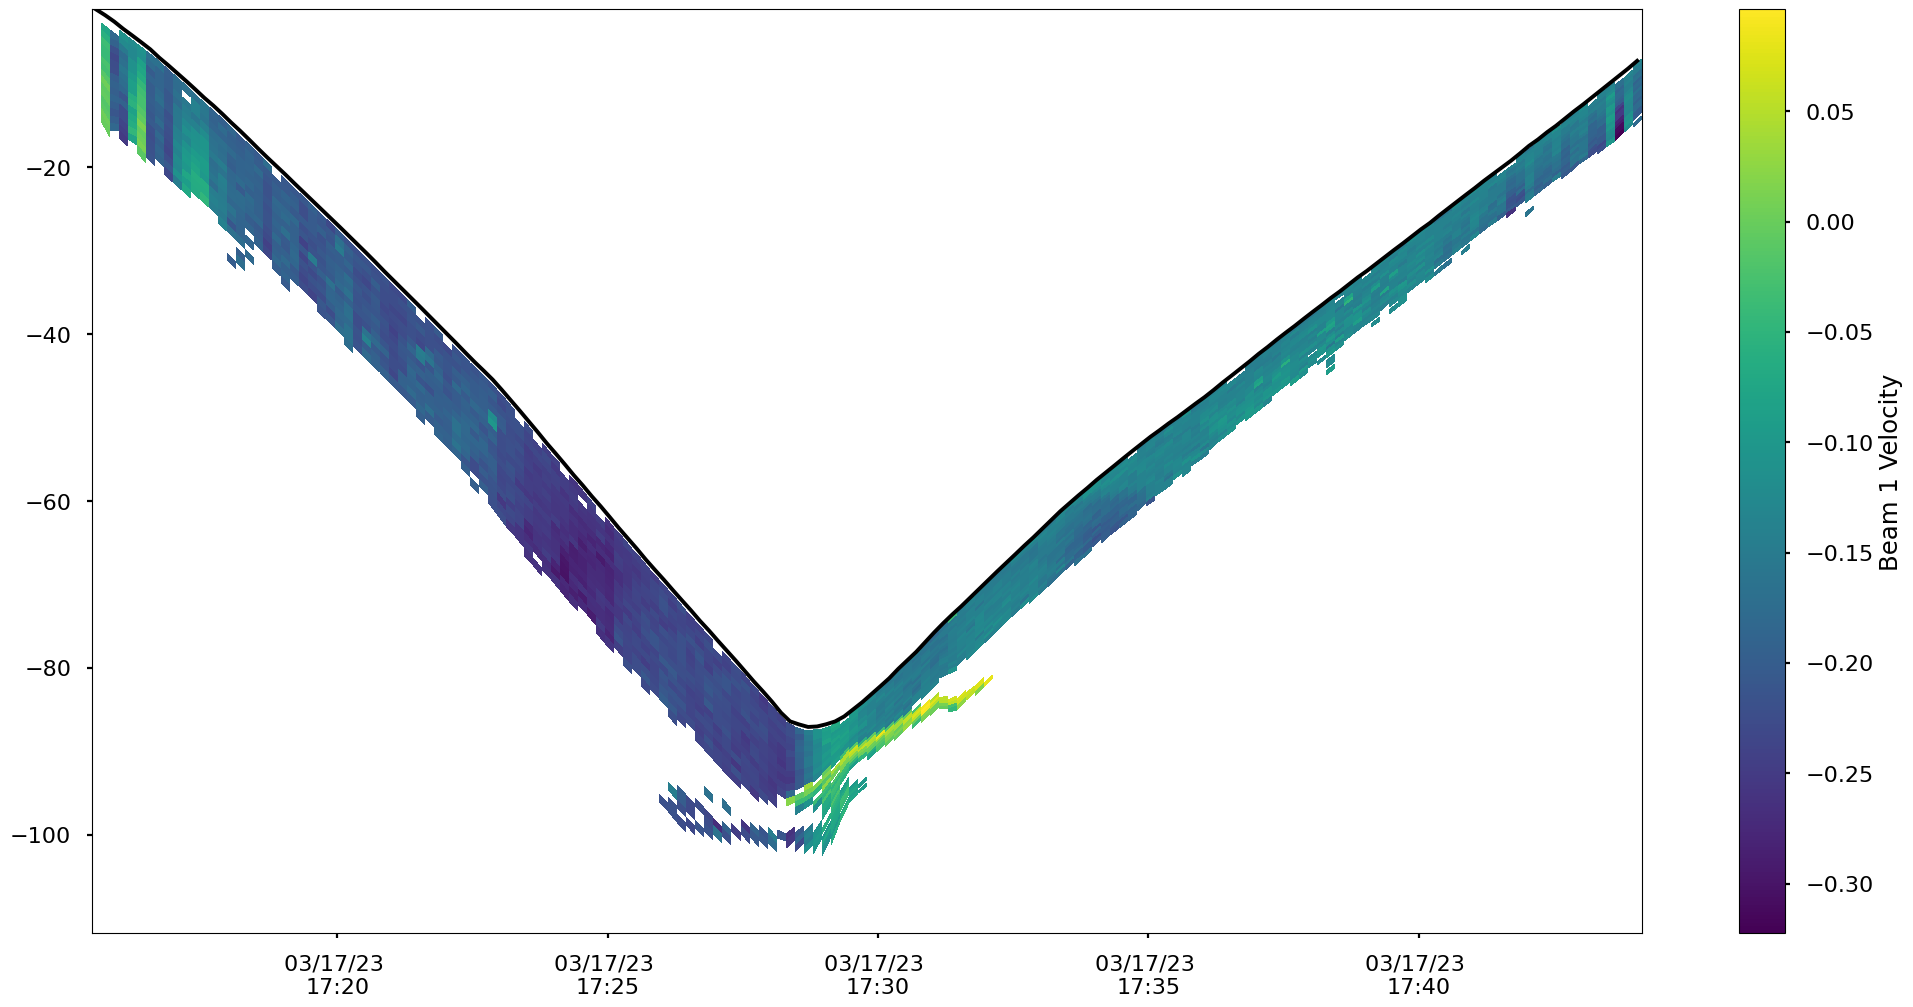

In [111]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])

by=subset_ad2cp['TrueDepthBeam1']+subset_ad2cp['Pressure']
fig = plt.figure(figsize=(25,12))
plt.pcolormesh(x,-by,subset_ad2cp['VelocityBeam1'])
plt.plot(subset_ad2cp['time'],-subset_ad2cp['Pressure'],'k')
plt.colorbar(label='Beam 1 Velocity')
plt.gca().xaxis.set_major_formatter(myFmtlong)

## Processing Step 7: Bin Mapping
Interpolate to set depth grid, this will also effectively filter out extreme pitch and roll

In [112]:
## Bin map
subset_ad2cp = binmap_adcp(subset_ad2cp)

### Take a peak at the bin mapped data

/var/folders/yg/ysrmd5rn6ws__r62wj_q7n400000gp/T/ipykernel_3416/2754214544.py:5: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(x,-by,subset_ad2cp['InterpVelocityBeam1'])


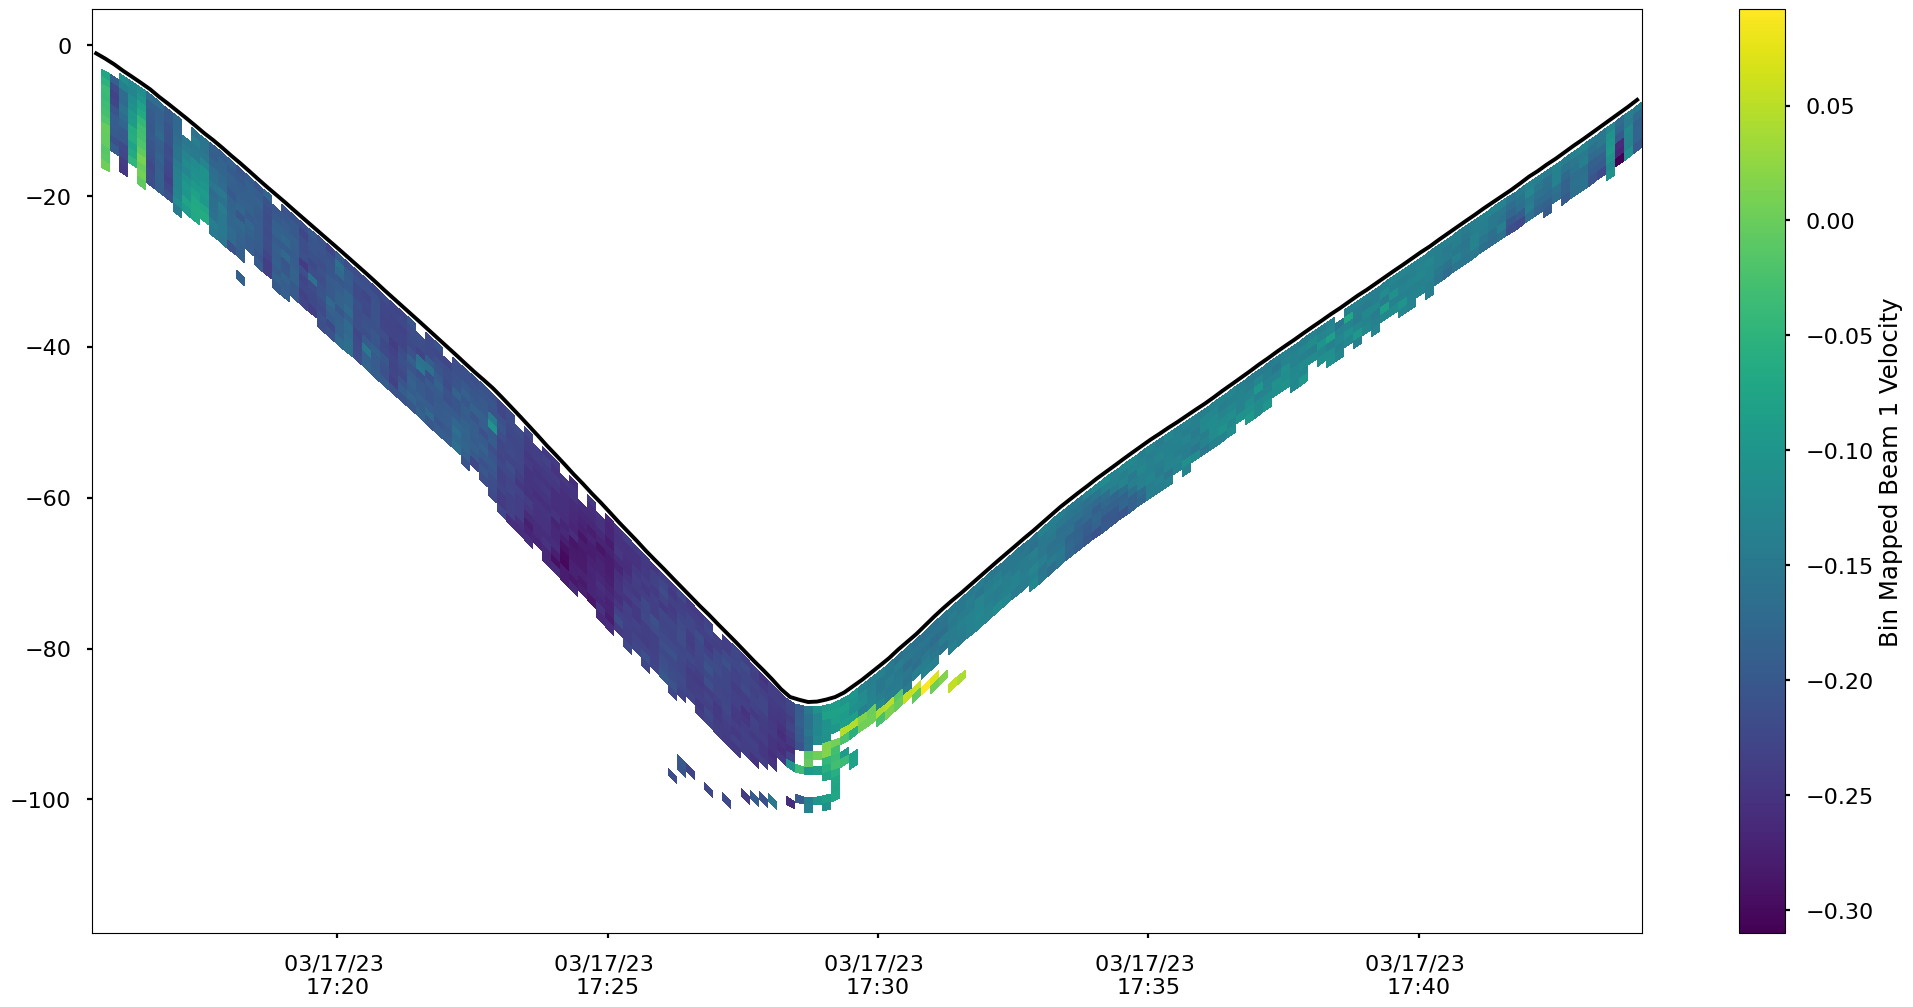

In [113]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Pressure'],subset_ad2cp['VelocityRange'])
by=bdepth+bbins
fig = plt.figure(figsize=(25,12))
plt.pcolormesh(x,-by,subset_ad2cp['InterpVelocityBeam1'])
plt.plot(subset_ad2cp['time'],-subset_ad2cp['Pressure'],'k')
plt.colorbar(label='Bin Mapped Beam 1 Velocity')
plt.gca().xaxis.set_major_formatter(myFmtlong)

## Processing Step 8: Convert from Beam to XYZ to ENU coordinates

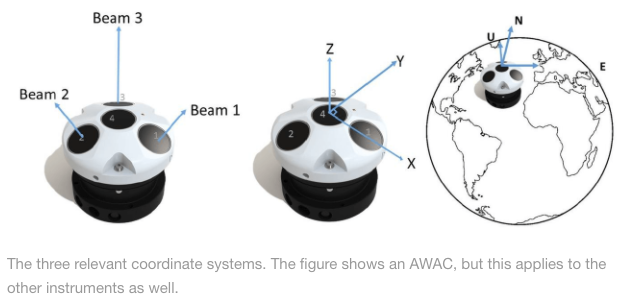

In [114]:
importlib.reload(NicolaiFunctions)
from NicolaiFunctions import calcAHRS,beam2enu

## Beam to ENU
subset_ad2cp2 = subset_ad2cp.copy();

# beam2xyz looks like this:
#     [0.6782, 0, -0.6782, 0],
#    [0, -1.1831, 0, 1.1831],
#    [0.74, 0, 0.74, 0],
#    [0, 0.5518, 0, 0.5518]
subset_ad2cp2.attrs['beam2xyz'] = tot_ad2cp.avg_beam2xyz.reshape(4,4)
RotMatrix=calcAHRS(subset_ad2cp2['CorrectedHeading'],subset_ad2cp2['Roll'],subset_ad2cp2['Pitch'])

# Get your conditions
subset_ad2cp2['AHRSRotationMatrix'] = (('x','time'), RotMatrix)
subset_ad2cp2 = beam2enu(subset_ad2cp2)

(9, 172)


### Take a peak at ENU data

/var/folders/yg/ysrmd5rn6ws__r62wj_q7n400000gp/T/ipykernel_3416/2706404986.py:7: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(x,-by,subset_ad2cp2['VVelocity'])


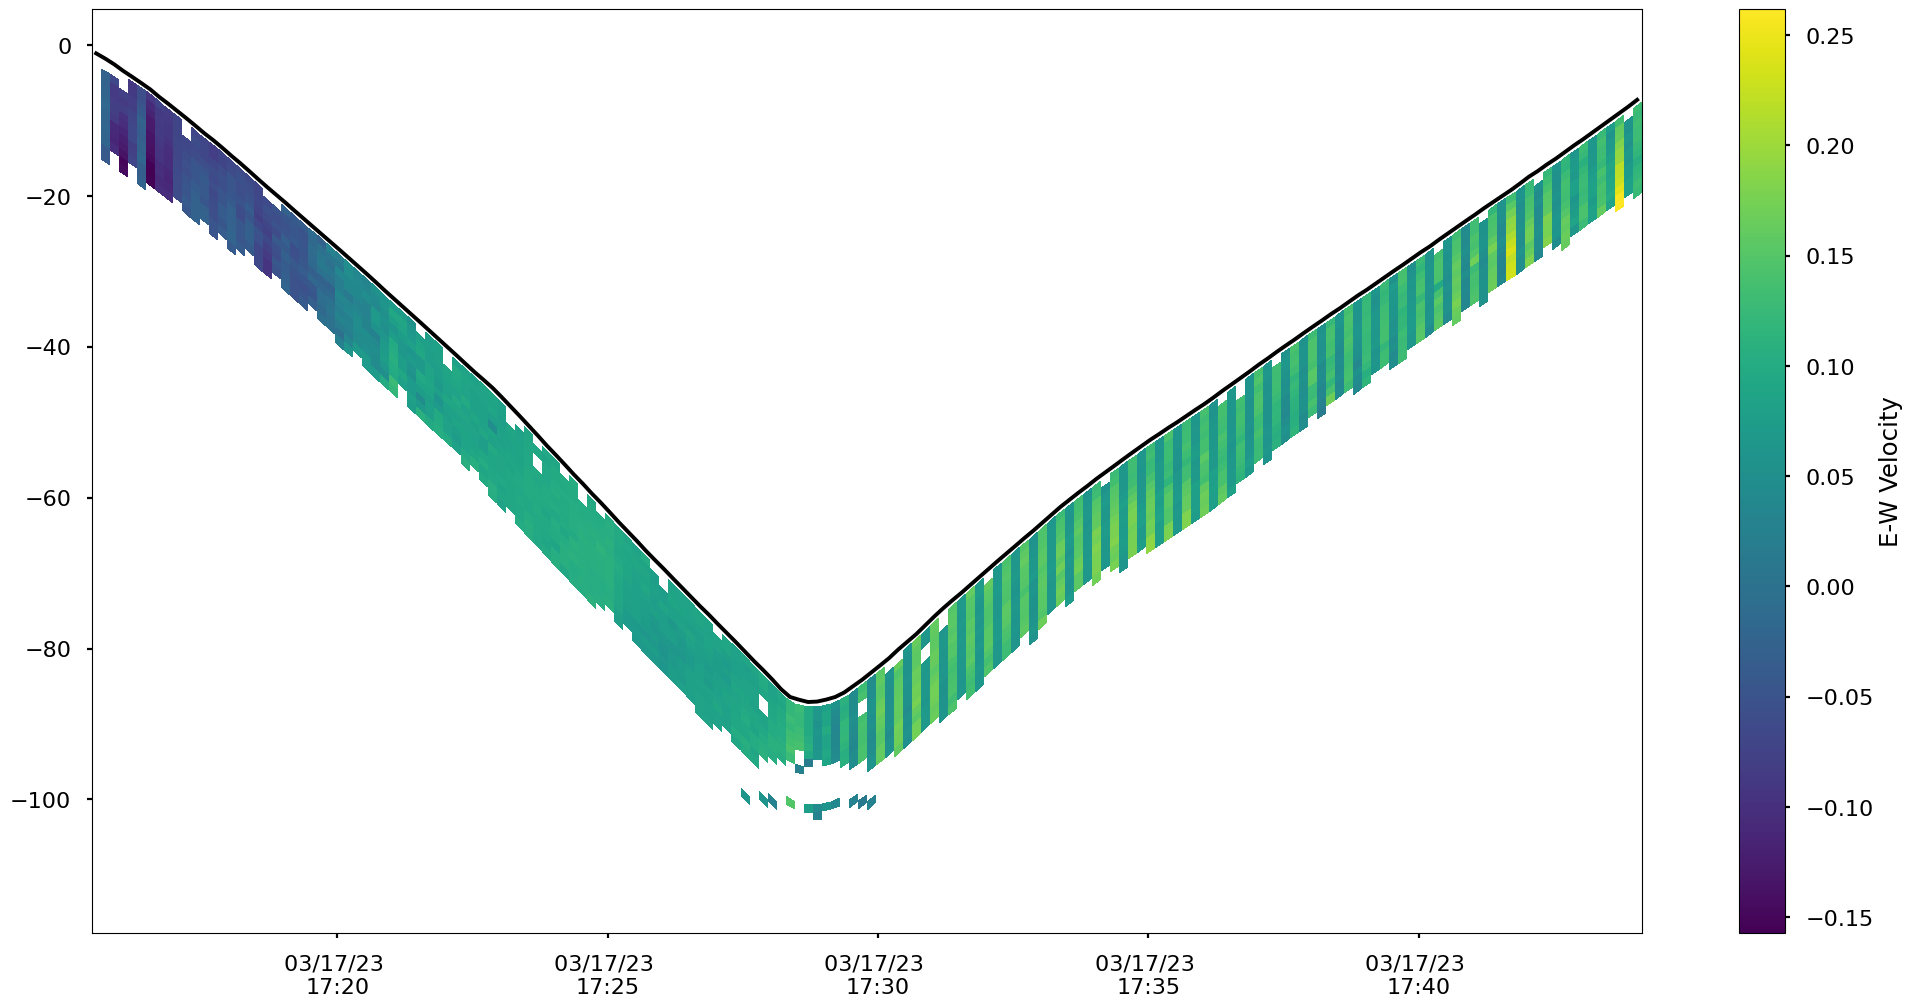

In [115]:
[x,y]=np.meshgrid(subset_ad2cp2['time'],subset_ad2cp2['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp2['Pressure'],subset_ad2cp2['VelocityRange'])

by=bdepth+bbins

fig = plt.figure(figsize=(25,12))
plt.pcolormesh(x,-by,subset_ad2cp2['VVelocity'])
plt.plot(subset_ad2cp2['time'],-subset_ad2cp2['Pressure'],'k')
plt.colorbar(label='E-W Velocity')
plt.gca().xaxis.set_major_formatter(myFmtlong)

## Filter out really high velocities relative to glider and first bin below glider

In [116]:
subset_ad2cp2 = qaqc_post_coord_transform(subset_ad2cp2, high_velocity_threshold=0.75, surface_depth_to_filter = 12)

/var/folders/yg/ysrmd5rn6ws__r62wj_q7n400000gp/T/ipykernel_3416/1109622606.py:7: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(x,-by,subset_ad2cp2['VVelocity'],vmin=-0.5,vmax=0.5,cmap='RdBu')


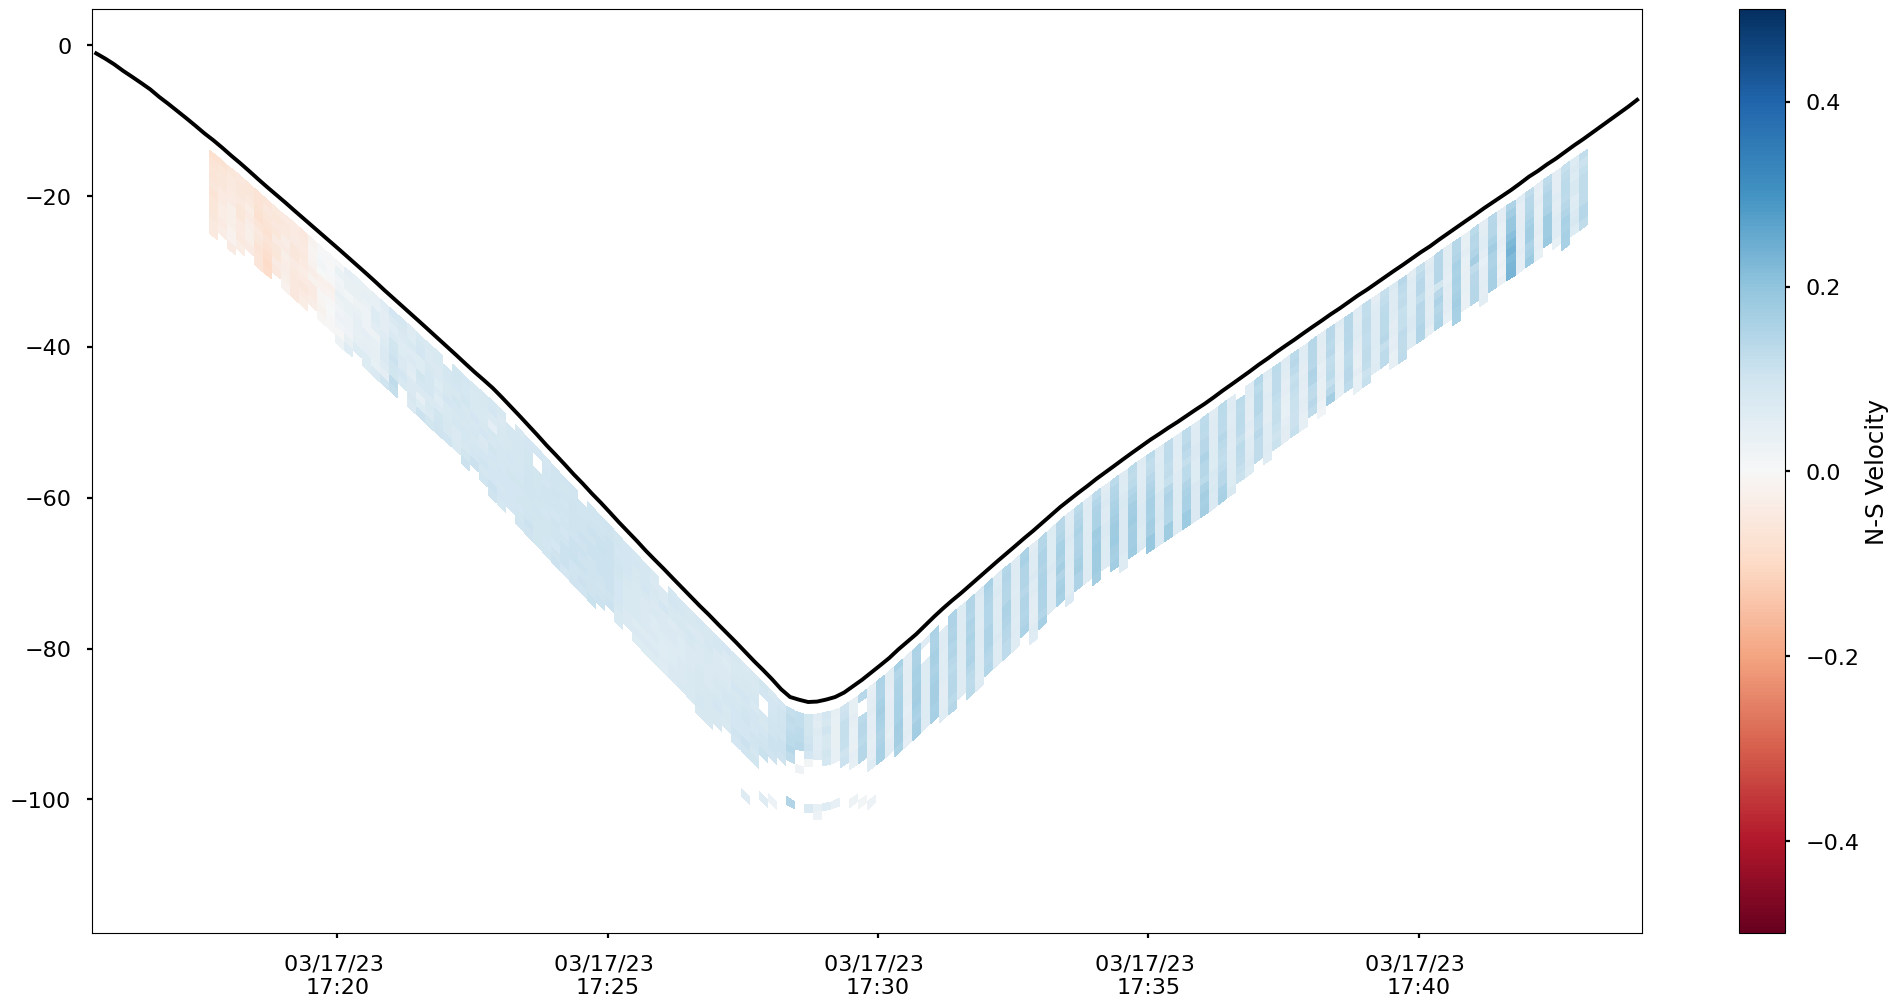

In [117]:
[x,y]=np.meshgrid(subset_ad2cp2['time'],subset_ad2cp2['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp2['Pressure'],subset_ad2cp2['VelocityRange'])

by=bdepth+bbins

fig = plt.figure(figsize=(25,12))
plt.pcolormesh(x,-by,subset_ad2cp2['VVelocity'],vmin=-0.5,vmax=0.5,cmap='RdBu')
plt.plot(subset_ad2cp2['time'],-subset_ad2cp2['Pressure'],'k')
plt.colorbar(label='N-S Velocity')
plt.gca().xaxis.set_major_formatter(myFmtlong)

## Processing Step 9: Run the inversion!

In [131]:
dz=1
wDAC = 5
wSmoothness = 1

importlib.reload(NicolaiFunctions)
from NicolaiFunctions import inversion

O_ls, G_ls, bin_new, obs_per_bin = inversion(subset_ad2cp2.UVelocity.values,subset_ad2cp2.VVelocity.values,
          dz,vx,vy,subset_ad2cp2['VelocityRange'].values,subset_ad2cp2['Pressure'].values, wDAC, wSmoothness)

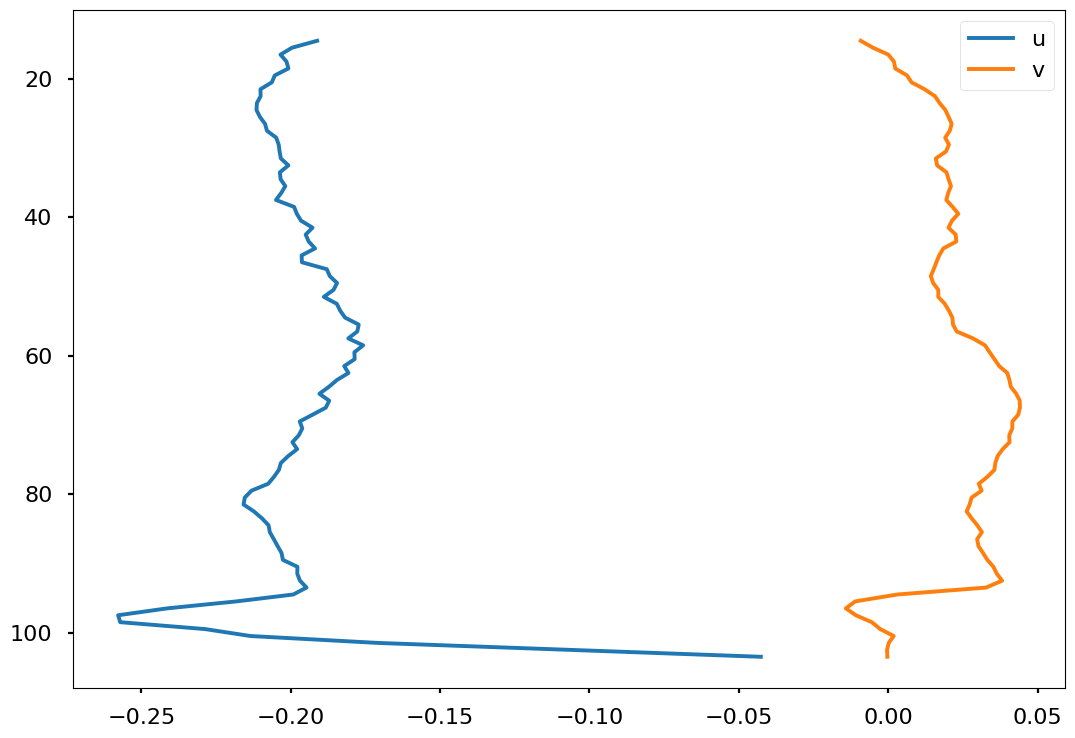

In [132]:
plt.plot(np.real(O_ls),bin_new,label='u')
plt.plot(np.imag(O_ls),bin_new,label='v')
plt.gca().invert_yaxis()
plt.legend()

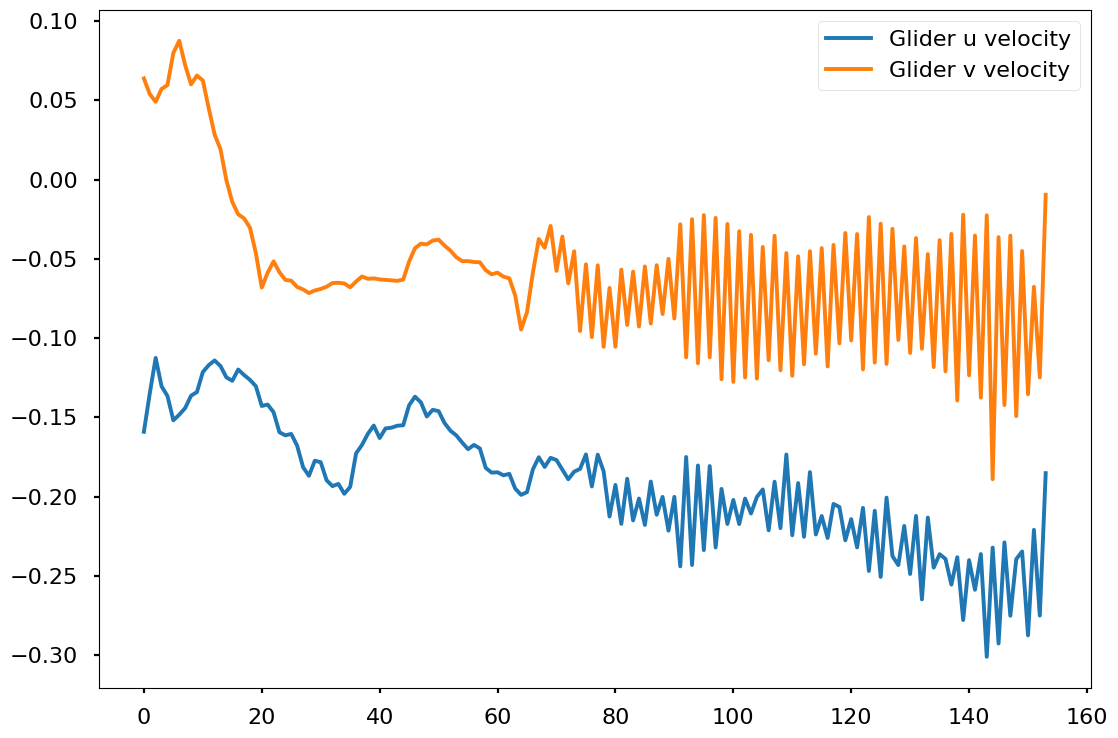

In [133]:
plt.plot(np.real(G_ls),label='Glider u velocity')
plt.plot(np.imag(G_ls),label='Glider v velocity')
plt.legend()

In [134]:
print('vx:',vx)
print('new caculated EW DAC:',np.nanmean(np.real(O_ls)))
print('vy:',vy)
print('new caculated NS DAC:',np.nanmean(np.imag(O_ls)))

vx: -0.16312059913793103
new caculated EW DAC: -0.19715412050086947
vy: 0.01984762543103448
new caculated NS DAC: 0.02173644403955576


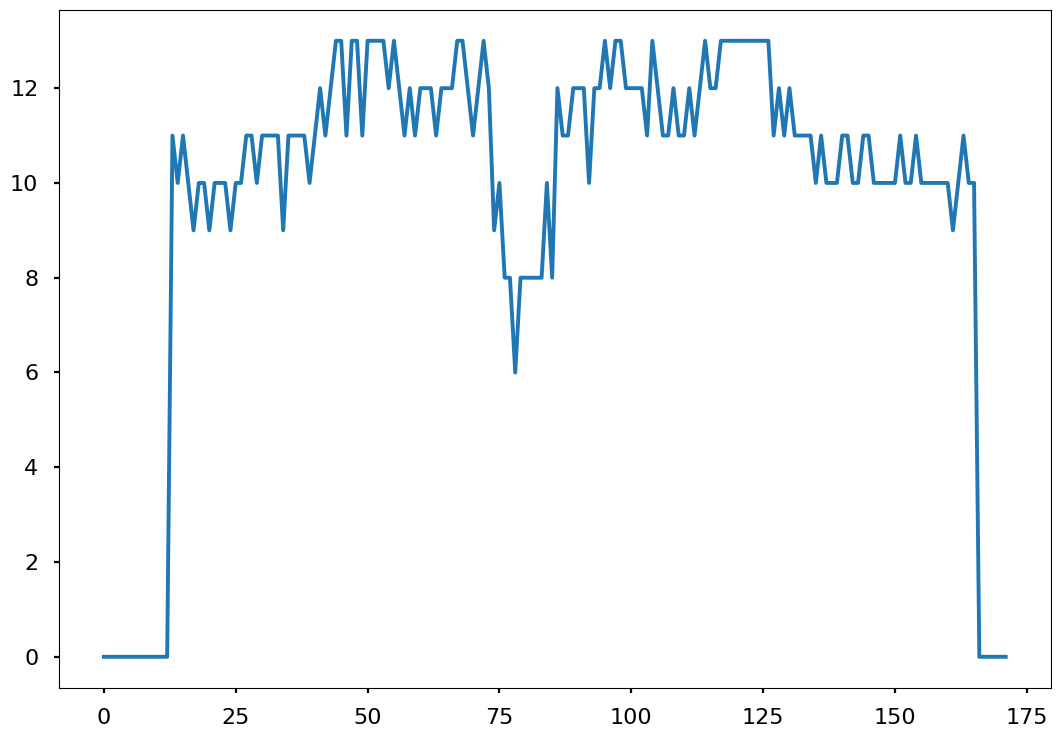

In [135]:
plt.plot(np.sum((np.isnan(U)==False),axis=0))

# Testing and Data Exploration

### Checking on pitch vattery-dependent magnetic heading correction

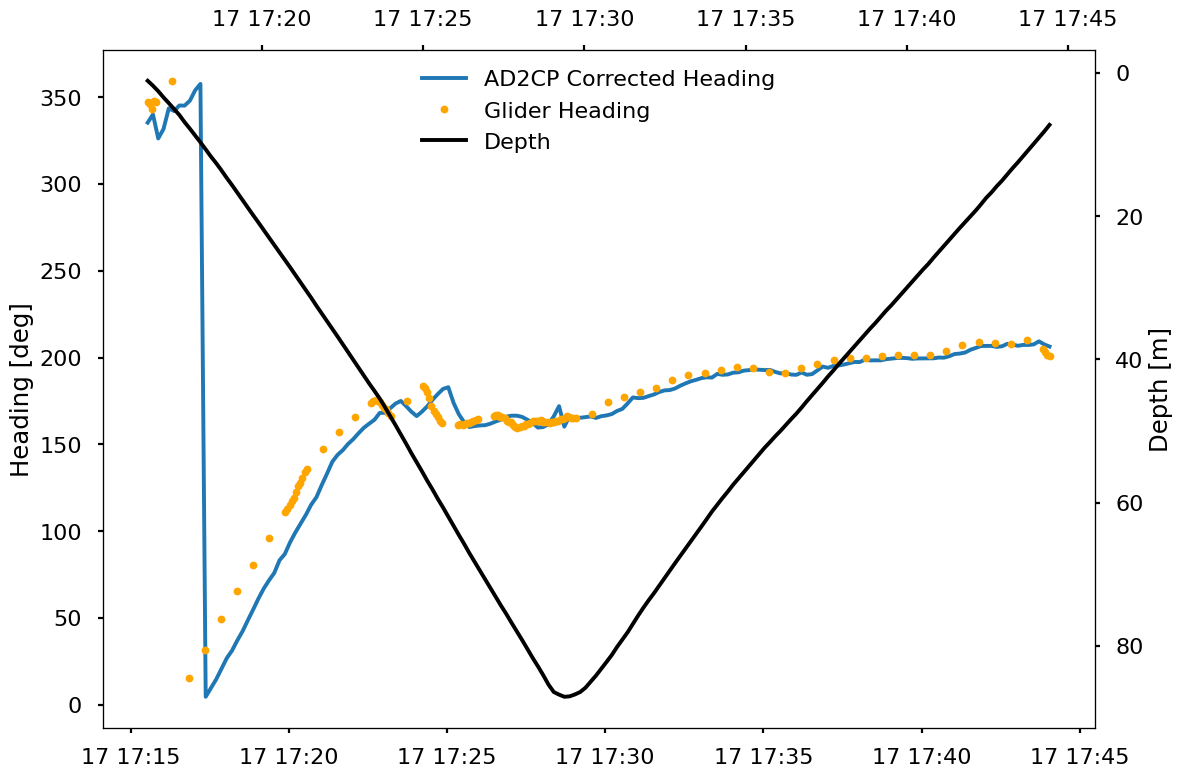

In [126]:
# x=28
# subsetgdf = gdf[(gdf.time >= start_times[x]) & (gdf.time <= end_times[x])]
# ad2cp_time_ind = np.where((tot_ad2cp.time >= start_times2[x]) & (tot_ad2cp.time <= end_times2[x]))[0]
# subset_ad2cp = tot_ad2cp.sel(time=tot_ad2cp.time[ad2cp_time_ind])

fig,ax = plt.subplots()
ln1 = ax.plot(subset_ad2cp2['time'],subset_ad2cp2['CorrectedHeading'],label='AD2CP Corrected Heading')
ax2=ax.twiny()
ln2 = ax2.plot(subsetgdf.time,subsetgdf.m_heading.values,'.',color='orange',label='Glider Heading')
ax.set_ylabel('Heading [deg]')
ax3=ax.twinx()
ln3 = ax3.plot(subset_ad2cp2.time,subset_ad2cp2.Pressure.values,color='black',label='Depth')
ax3.invert_yaxis()
ax3.set_ylabel('Depth [m]')
lns = ln1+ln2+ln3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=9,frameon=False)